# Data 144 Final Project: Main Team Notebook

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Import Datasets

This dataset provides a complete overview of all international soccer matches played since the 90s. On top of that, the strength of each team is provided by incorporating actual FIFA rankings as well as player strengths based on the EA Sport FIFA video game.

In [ ]:
original = pd.read_csv('https://raw.githubusercontent.com/wsharvey/Data/main/international_matches.csv')
df = original.copy()
print('Num Rows: {}'.format(df.shape[0]))
df.tail(3)

Num Rows: 23921


,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# Data Exploration

## Column names and null values

In [ ]:
#column names
df.columns

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

In [ ]:
#finding null values
df.isna().sum()

date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

## Exploring importance of FIFA rank in win/lose/draw

In [ ]:
better_fifa_rank_won = []
for i in np.arange(df.shape[0]):
  if df['home_team_result'][i] == 'Win':
    if df['home_team_fifa_rank'][i] < df['away_team_fifa_rank'][i]:
      better_fifa_rank_won.append(1)
    else:
      better_fifa_rank_won.append(0)
  elif df['home_team_result'][i] == 'Lose':
    if df['home_team_fifa_rank'][i] > df['away_team_fifa_rank'][i]:
      better_fifa_rank_won.append(1)
    else:
      better_fifa_rank_won.append(0)
  else:
    better_fifa_rank_won.append(0)

In [ ]:
df_copy = df.copy()
df_copy['better_fifa_rank_won'] = better_fifa_rank_won
df_copy[['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', 'better_fifa_rank_won']]

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,better_fifa_rank_won
0,Bolivia,Uruguay,59,22,0
1,Brazil,Mexico,8,14,0
2,Ecuador,Venezuela,35,94,1
3,Guinea,Sierra Leone,65,86,1
4,Paraguay,Argentina,67,5,1
...,...,...,...,...,...
23916,Moldova,Andorra,180,153,0
23917,Liechtenstein,Latvia,192,135,1
23918,Chile,Ghana,28,60,0
23919,Japan,Tunisia,23,35,0


In [ ]:
#calculate percent of times higher fifa rank wins using df excluding games with draws
no_draws = df_copy[df_copy['home_team_result'] != 'Draw']
percent_higher_fifa_wins = sum(no_draws['better_fifa_rank_won'])/no_draws.shape[0] * 100
percent_higher_fifa_wins

71.75156486078134

## Exploring home team advantage

Perentage of time the home team won, lost, and tied.

In [ ]:
#percentage of times home team wins vs away team wins vs draws
home_team_win = sum(df_copy['home_team_result'] == 'Win')/df_copy.shape[0] * 100
away_team_win = sum(df_copy['home_team_result'] == 'Lose')/df_copy.shape[0] * 100
draw_result = sum(df_copy['home_team_result'] == 'Draw')/df_copy.shape[0] * 100
print(home_team_win, away_team_win, draw_result)

49.166004765687056 28.305672839764224 22.528322394548724


Data frame with each row representing a country and containing information about how many times they won when they were the home team.


In [ ]:
df_copy2 = pd.DataFrame()

home_draws = df_copy[df_copy['home_team_result']=='Draw'].groupby(['home_team'])['home_team_result'].count()
home_wins = df_copy[df_copy['home_team_result']=='Win'].groupby(['home_team'])['home_team_result'].count()
home_losses = df_copy[df_copy['home_team_result']=='Lose'].groupby(['home_team'])['home_team_result'].count()

df_copy2['home_games'] = df_copy.groupby('home_team')['date'].count()
df_copy2['home_team_wins'] = home_wins
df_copy2['home_team_draws'] = home_draws
df_copy2['home_team_losses'] = home_losses
df_copy2['home_team_wins_at_home_ratio'] = df_copy2['home_team_wins'] / df_copy2['home_games']
df_copy2

,home_games,home_team_wins,home_team_draws,home_team_losses,home_team_wins_at_home_ratio
home_team,,,,,
Afghanistan,36,16,8.0,12,0.444444
Albania,131,52,30.0,49,0.396947
Algeria,159,91,30.0,38,0.572327
American Samoa,17,3,1.0,13,0.176471
Andorra,97,10,13.0,74,0.103093
...,...,...,...,...,...
Vietnam,120,57,28.0,35,0.475000
Wales,129,53,33.0,43,0.410853
Yemen,87,27,22.0,38,0.310345


Filter to show countries who win at home more than 60% of the time.

In [ ]:
df_copy2[df_copy2['home_team_wins_at_home_ratio']>0.60]

,home_games,home_team_wins,home_team_draws,home_team_losses,home_team_wins_at_home_ratio
home_team,,,,,
Argentina,190,130,36.0,24,0.684211
Australia,169,112,26.0,31,0.662722
Brazil,233,181,31.0,21,0.776824
Czech Republic,153,100,19.0,34,0.653595
Côte d'Ivoire,154,100,32.0,22,0.649351
Egypt,227,163,29.0,35,0.718062
England,194,124,38.0,32,0.639175
France,221,145,44.0,32,0.656109
Germany,219,139,44.0,36,0.634703


## Visualizing FIFA rank vs. FIFA points

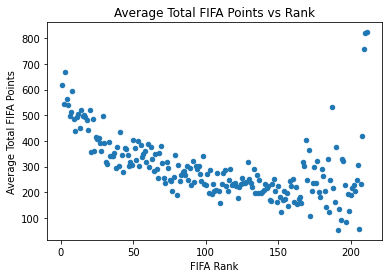

In [ ]:
original.groupby('home_team_fifa_rank')\
        .agg({'home_team_total_fifa_points': 'mean'})\
        .reset_index()\
        .plot.scatter(x = 'home_team_fifa_rank', y = 'home_team_total_fifa_points')
plt.title('Average Total FIFA Points vs Rank')
plt.xlabel('FIFA Rank')
plt.ylabel('Average Total FIFA Points')
plt.show()

Looking at the scatter plot, we see the FIFA points do not follow the trend around a FIFA ranking of 150. Most lower ranked teams will not make it into the World Cup anyways so it will probably be beneficial to only look at the top 100 teams.

# Data Preparation and Feature Engineering

In [ ]:
# Only look at games with teams in top 150 fifa rank
df = df[(df.home_team_fifa_rank <= 100) & (df.away_team_fifa_rank <= 100)]

# Win, Loss, or Draw
df["num_home_team_result"] = df.replace({"home_team_result": {"Win":1, "Draw":0, "Lose":0}})["home_team_result"]

# One-hot encode friendly, world cup
df["FIFA_World_Cup"] = pd.get_dummies(df.tournament)["FIFA World Cup"]
df["FIFA_World_Cup_qualification"] = pd.get_dummies(df.tournament)["FIFA World Cup qualification"]
df["Friendly"] = pd.get_dummies(df.tournament)["Friendly"]
df["Other"] = (1 - df.Friendly - df.FIFA_World_Cup - df.FIFA_World_Cup_qualification)

# Rank difference = The fifa rank difference between the teams at the time of the game 
# Positive means the home team is ranked more strongly
df['rank_difference'] = df.away_team_fifa_rank - df.home_team_fifa_rank
df['total_point_diff'] = df.home_team_total_fifa_points - df.away_team_total_fifa_points
df['goalkeeper_diff'] = df.home_team_goalkeeper_score - df.away_team_goalkeeper_score
df['defense_diff'] = df.home_team_mean_defense_score - df.away_team_mean_defense_score
df['offense_diff'] = df.home_team_mean_offense_score - df.away_team_mean_offense_score
df['midfield_diff'] = df.home_team_mean_midfield_score - df.away_team_mean_midfield_score

# Rank Ratios
df['rank_ratio'] = df.away_team_fifa_rank / df.home_team_fifa_rank
df['total_point_ratio'] = df.home_team_total_fifa_points / df.away_team_total_fifa_points
df['goalkeeper_ratio'] = df.home_team_goalkeeper_score / df.away_team_goalkeeper_score
df['defense_ratio'] = df.home_team_mean_defense_score / df.away_team_mean_defense_score
df['offense_ratio'] = df.home_team_mean_offense_score / df.away_team_mean_offense_score
df['midfield_ratio'] = df.home_team_mean_midfield_score / df.away_team_mean_midfield_score

df["home_attacking_advantage"] = ((df.home_team_mean_offense_score + df.home_team_mean_midfield_score)/2) - ((df.away_team_mean_defense_score + df.away_team_goalkeeper_score)/2)
df["away_attacking_advantage"] = ((df.away_team_mean_offense_score + df.away_team_mean_midfield_score)/2) - ((df.home_team_mean_defense_score + df.home_team_goalkeeper_score)/2)

# Only Cup Games
cups = ["FIFA World Cup", "Copa América", "FIFA World Cup qualification", 
        "UEFA Nations League", "CONCACAF Nations League"]
df = df[df.tournament.isin(cups)]

# Drop null rows
df.dropna(inplace = True)

df.head(3)

<ipython-input-12-eaa955b1e90a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_home_team_result"] = df.replace({"home_team_result": {"Win":1, "Draw":0, "Lose":0}})["home_team_result"]
<ipython-input-12-eaa955b1e90a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FIFA_World_Cup"] = pd.get_dummies(df.tournament)["FIFA World Cup"]
<ipython-input-12-eaa955b1e90a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,offense_diff,midfield_diff,rank_ratio,total_point_ratio,goalkeeper_ratio,defense_ratio,offense_ratio,midfield_ratio,home_attacking_advantage,away_attacking_advantage
14421,2011-10-07,Argentina,Chile,South America,South America,10,14,1024,932,4,...,8.0,4.4,1.400000,1.098712,0.987179,1.114483,1.099626,1.054455,11.50,1.65
14438,2011-10-07,Ecuador,Venezuela,South America,South America,69,47,481,597,2,...,1.0,1.3,0.681159,0.805695,1.078125,0.976454,1.013569,1.017219,7.65,4.85
14450,2011-10-07,Peru,Paraguay,South America,South America,35,24,723,824,2,...,-3.0,5.5,0.685714,0.877427,1.057971,0.975275,0.962500,1.075862,6.60,4.25


In [ ]:
d1 = df[['home_team', 'home_team_score', 'away_team_score']].rename({'home_team': 'team',
                                                                'home_team_score':'avg_goals_scored',
                                                                'away_team_score': 'avg_goals_conceded'}, axis = 1)
d2 = df[['away_team', 'away_team_score', 'home_team_score']].rename({'away_team': 'team',
                                                                'away_team_score':'avg_goals_scored',
                                                                'home_team_score': 'avg_goals_conceded'}, axis = 1)
scored_conceded = pd.concat([d1, d2]).groupby('team').mean().reset_index()

## Engineering New Features

In [ ]:
d1 = df[['home_team', 'home_team_score', 'away_team_score']].rename({'home_team': 'team',
                                                                'home_team_score':'avg_goals_scored',
                                                                'away_team_score': 'avg_goals_conceded'}, axis = 1)
d2 = df[['away_team', 'away_team_score', 'home_team_score']].rename({'away_team': 'team',
                                                                'away_team_score':'avg_goals_scored',
                                                                'home_team_score': 'avg_goals_conceded'}, axis = 1)
scored_conceded = pd.concat([d1, d2]).groupby('team').mean().reset_index()

In [ ]:
df = df.merge(scored_conceded, left_on = 'home_team', right_on = 'team')\
       .drop('team', axis = 1)
df = df.merge(scored_conceded, left_on = 'away_team', right_on = 'team', suffixes = ('_home', '_away'))\
       .drop('team', axis = 1).sort_values('date')
df.head(3)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,goalkeeper_ratio,defense_ratio,offense_ratio,midfield_ratio,home_attacking_advantage,away_attacking_advantage,avg_goals_scored_home,avg_goals_conceded_home,avg_goals_scored_away,avg_goals_conceded_away
0,2011-10-07,Argentina,Chile,South America,South America,10,14,1024,932,4,...,0.987179,1.114483,1.099626,1.054455,11.50,1.65,1.621951,0.792683,1.447368,1.328947
155,2011-10-07,Ecuador,Venezuela,South America,South America,69,47,481,597,2,...,1.078125,0.976454,1.013569,1.017219,7.65,4.85,1.268657,1.328358,0.848485,1.590909
85,2011-10-07,Peru,Paraguay,South America,South America,35,24,723,824,2,...,1.057971,0.975275,0.962500,1.075862,6.60,4.25,1.197183,1.436620,0.926471,1.500000


In [ ]:
df[['num_home_team_result', 'date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score',
       'FIFA_World_Cup',
       'FIFA_World_Cup_qualification', 'Friendly', 'Other', 'rank_difference',
       'total_point_diff', 'goalkeeper_diff', 'defense_diff', 'offense_diff',
       'midfield_diff', 'rank_ratio', 'total_point_ratio', 'goalkeeper_ratio',
       'defense_ratio', 'offense_ratio', 'midfield_ratio',
       'home_attacking_advantage', 'away_attacking_advantage',
       'avg_goals_scored_home', 'avg_goals_conceded_home',
       'avg_goals_scored_away', 'avg_goals_conceded_away']].corr().sort_values('num_home_team_result', ascending = False)

,num_home_team_result,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,neutral_location,home_team_goalkeeper_score,away_team_goalkeeper_score,...,goalkeeper_ratio,defense_ratio,offense_ratio,midfield_ratio,home_attacking_advantage,away_attacking_advantage,avg_goals_scored_home,avg_goals_conceded_home,avg_goals_scored_away,avg_goals_conceded_away
num_home_team_result,1.000000,-0.195740,0.231231,0.087714,-0.142781,0.628264,-0.503130,-0.051282,0.161775,-0.235727,...,0.300402,0.339452,0.352423,0.372511,0.363830,-0.355011,0.264823,-0.212530,-0.271589,0.275888
home_team_score,0.628264,-0.185515,0.222639,0.064755,-0.153144,1.000000,-0.082923,-0.091801,0.167862,-0.214185,...,0.292913,0.325654,0.301075,0.351539,0.347815,-0.313569,0.339592,-0.150273,-0.151834,0.317286
midfield_diff,0.376789,-0.511733,0.497714,0.265608,-0.282647,0.351669,-0.278522,0.094253,0.449374,-0.450985,...,0.687902,0.827531,0.778862,0.997188,0.850200,-0.856302,0.485920,-0.523037,-0.466016,0.486307
midfield_ratio,0.372511,-0.503430,0.504765,0.258410,-0.282952,0.351539,-0.275369,0.090272,0.442311,-0.454187,...,0.688949,0.822442,0.775886,1.000000,0.843673,-0.852187,0.474448,-0.514200,-0.457415,0.493603
home_attacking_advantage,0.363830,-0.517886,0.454234,0.204293,-0.340072,0.347815,-0.261688,0.153917,0.377174,-0.670126,...,0.798826,0.863180,0.840515,0.843673,1.000000,-0.755808,0.504265,-0.501467,-0.391724,0.523938
offense_diff,0.355412,-0.501169,0.461573,0.289515,-0.251426,0.300977,-0.293395,0.115612,0.416732,-0.408291,...,0.626235,0.805215,0.996765,0.773244,0.844466,-0.839337,0.424783,-0.492167,-0.400782,0.442713
offense_ratio,0.352423,-0.499043,0.462235,0.286895,-0.247031,0.301075,-0.290605,0.113332,0.417103,-0.407849,...,0.628694,0.802709,1.000000,0.775886,0.840515,-0.838337,0.421874,-0.485937,-0.395817,0.440454
defense_diff,0.342689,-0.508786,0.461173,0.283896,-0.255931,0.326145,-0.266493,0.083755,0.453001,-0.444038,...,0.681623,0.997635,0.802184,0.820548,0.863674,-0.858481,0.459105,-0.550788,-0.398418,0.496362
defense_ratio,0.339452,-0.508422,0.465239,0.278341,-0.258643,0.325654,-0.265076,0.081646,0.450611,-0.446619,...,0.685021,1.000000,0.802709,0.822442,0.863180,-0.855663,0.456630,-0.547047,-0.387820,0.501082
rank_difference,0.314735,-0.678084,0.678552,0.337820,-0.348535,0.300866,-0.248941,0.096572,0.375727,-0.390608,...,0.590310,0.717693,0.708566,0.743158,0.716553,-0.716695,0.378996,-0.462304,-0.387112,0.458050


## Vizualize new dataset

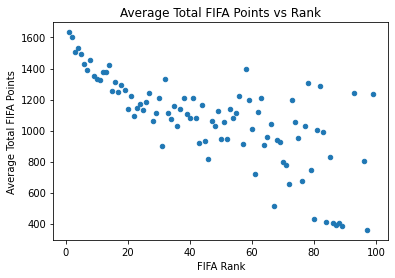

In [ ]:
df.groupby('home_team_fifa_rank')\
  .agg({'home_team_total_fifa_points': 'mean'})\
  .reset_index()\
  .plot.scatter(x = 'home_team_fifa_rank', y = 'home_team_total_fifa_points')
plt.title('Average Total FIFA Points vs Rank')
plt.xlabel('FIFA Rank')
plt.ylabel('Average Total FIFA Points')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


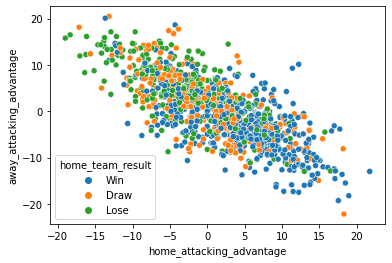

In [ ]:
sns.scatterplot(df.home_attacking_advantage, df.away_attacking_advantage, hue = df.home_team_result);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


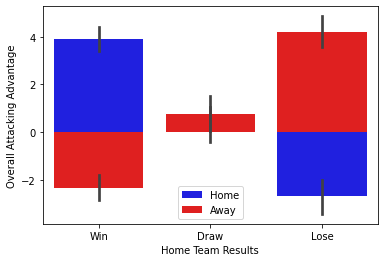

In [ ]:
ax = plt.subplots()
ax = sns.barplot(df.home_team_result, df.home_attacking_advantage, orient='v', color = 'b', label = 'Home')
ax = sns.barplot(df.home_team_result, df.away_attacking_advantage, orient='v', color = 'r', label = 'Away')
ax.set(xlabel='Home Team Results', ylabel='Overall Attacking Advantage')
plt.legend()
plt.show();

The barplot above shows the results of our "overall attacking advantage" feature on win-draw-loss prediction. As we can see, wins for the home team are accompanied by high positive home team overall attacking advantage and negative away team overall attacking advantage. Furthermore, loses for the home team are accompanied by negative home team overall attacking advantage and high positive away team overall attacking advantage. It is also interesting to notice that draws tend to occur when either team has a low positive overall attacking advantage. 

# Creating Our Model

## Random Forest

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
features = ['midfield_diff', 'defense_diff', 'offense_diff', 'home_attacking_advantage', 
            'rank_difference', 'goalkeeper_diff', 'avg_goals_conceded_away', 'avg_goals_scored_home', 
            'away_team_fifa_rank', 'total_point_ratio', "home_team_mean_midfield_score",
            'home_team_mean_offense_score', 'home_team_mean_defense_score', 'away_team_goalkeeper_score', 
            'avg_goals_conceded_home', 'away_team_mean_defense_score', "away_team_mean_midfield_score",
            'away_team_mean_offense_score', 'avg_goals_scored_away', 'away_attacking_advantage', 'home_team_fifa_rank',
            'home_team_goalkeeper_score', 'neutral_location']
X = df[features]
y = df['num_home_team_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
params = {"max_depth": [4, 8],
                "min_samples_split": [2, 6, 12, 16],
                "max_leaf_nodes": [None, 100],
                "min_samples_leaf": [2, 5, 8],
                "n_estimators": [250]
                }

clf = RandomForestClassifier(random_state=1)

clf_cv = GridSearchCV(clf, params, cv = 3, n_jobs = -1, verbose = False)

clf_cv.fit(X_train.values, np.ravel(y_train))
clf = clf_cv.best_estimator_
clf

RandomForestClassifier(max_depth=8, max_leaf_nodes=100, min_samples_leaf=2,
                       min_samples_split=16, n_estimators=250, random_state=1)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores.mean()

0.673913043478261

## Fitting Our Model

In [ ]:
model = clf
model.fit(X, y)

RandomForestClassifier(max_depth=8, max_leaf_nodes=100, min_samples_leaf=2,
                       min_samples_split=16, n_estimators=250, random_state=1)

To overcome the home field advantage bias that is implicitly present in our model, we will simulate each match twice. Once where team A is the home team and once where team B is the home team.

In [ ]:
def home_away_reverse(X):
  swap = X.copy()
  swap.midfield_diff = X.midfield_diff * -1
  swap.defense_diff = X.defense_diff * -1
  swap.offense_diff = X.offense_diff * -1
  swap.home_attacking_advantage = X.away_attacking_advantage
  swap.rank_difference = X.rank_difference * -1
  swap.goalkeeper_diff = X.goalkeeper_diff * -1
  swap.avg_goals_conceded_away = X.avg_goals_conceded_home
  swap.avg_goals_scored_home = X.avg_goals_scored_away
  swap.away_team_fifa_rank = X.home_team_fifa_rank
  swap.total_point_ratio = 1 / X.total_point_ratio
  swap.home_team_mean_midfield_score = X.away_team_mean_midfield_score
  swap.home_team_mean_offense_score = X.away_team_mean_offense_score
  swap.home_team_mean_defense_score = X.away_team_mean_defense_score
  swap.away_team_goalkeeper_score = X.home_team_goalkeeper_score
  swap.avg_goals_conceded_home = X.avg_goals_conceded_away
  swap.away_team_mean_defense_score = X.home_team_mean_defense_score
  swap.away_team_mean_midfield_score = X.home_team_mean_midfield_score
  swap.away_team_mean_offense_score = X.home_team_mean_offense_score
  swap.avg_goals_scored_away = X.avg_goals_scored_home
  swap.away_attacking_advantage = X.home_attacking_advantage
  swap.home_team_fifa_rank = X.away_team_fifa_rank
  swap.home_team_goalkeeper_score = X.away_team_goalkeeper_score
  return swap

# Creating Test Set

In [ ]:
teams = [['Spain', 7, 'E'], ['Costa Rica', 31, 'E'], ['Germany', 11, 'E'],
['Japan', 24, 'E'],
['Belgium', 2, 'F'],
['Canada', 41, 'F'],
['Morocco', 22, 'F'],
['Croatia', 12, 'F'],
['Brazil', 1, 'G'],
['Serbia', 21, 'G'],
['Switzerland', 15, 'G'],
['Cameroon', 43, 'G'],
['Portugal', 9, 'H'],
['Ghana', 61, 'H'],
['Uruguay', 14, 'H'],
['South Korea', 28, 'H'], ['Qatar', 50, 'A'], ['Ecuador', 44, 'A'], ['Senegal', 18, 'A'], ['Netherlands', 8, 'A'],
['England', 5, 'B'], ['Iran', 20, 'B'], ['United States', 16, 'B'], ['Wales', 19, 'B'],
['Argentina', 3, 'C'], ['Saudia Arabia', 51, 'C'], ['Mexico', 13, 'C'], ['Poland', 26, 'C'],
['France', 4, 'D'], ['Australia', 38, 'D'], ['Denmark', 10, 'D'], ['Tunisia', 30, 'D']]
bottom = pd.DataFrame(data = teams, columns = ['Team', 'FIFA Ranking', 'Group'] )

Get all the matchups in group stage

In [ ]:
from itertools import combinations


matchups = []
for g in bottom['Group'].unique():
  df_ = bottom[bottom['Group'] == g]
  teams = list(df_['Team'])
  combos = list(combinations(teams, 2))
  matchups.append(combos)

matchups


[[('Spain', 'Costa Rica'),
  ('Spain', 'Germany'),
  ('Spain', 'Japan'),
  ('Costa Rica', 'Germany'),
  ('Costa Rica', 'Japan'),
  ('Germany', 'Japan')],
 [('Belgium', 'Canada'),
  ('Belgium', 'Morocco'),
  ('Belgium', 'Croatia'),
  ('Canada', 'Morocco'),
  ('Canada', 'Croatia'),
  ('Morocco', 'Croatia')],
 [('Brazil', 'Serbia'),
  ('Brazil', 'Switzerland'),
  ('Brazil', 'Cameroon'),
  ('Serbia', 'Switzerland'),
  ('Serbia', 'Cameroon'),
  ('Switzerland', 'Cameroon')],
 [('Portugal', 'Ghana'),
  ('Portugal', 'Uruguay'),
  ('Portugal', 'South Korea'),
  ('Ghana', 'Uruguay'),
  ('Ghana', 'South Korea'),
  ('Uruguay', 'South Korea')],
 [('Qatar', 'Ecuador'),
  ('Qatar', 'Senegal'),
  ('Qatar', 'Netherlands'),
  ('Ecuador', 'Senegal'),
  ('Ecuador', 'Netherlands'),
  ('Senegal', 'Netherlands')],
 [('England', 'Iran'),
  ('England', 'United States'),
  ('England', 'Wales'),
  ('Iran', 'United States'),
  ('Iran', 'Wales'),
  ('United States', 'Wales')],
 [('Argentina', 'Saudia Arabia'),
  (

Get the rankings of both teams in the matchup

In [ ]:
to_df = []
for x in range(8):
  group = matchups[x]
  for y in range(6):
    game = group[y]
    r1 = bottom[bottom['Team'] == game[0]]['FIFA Ranking'].iloc[0]
    r2 = bottom[bottom['Team'] == game[1]]['FIFA Ranking'].iloc[0]
    my_list = [game[0], game[1], r1, r2]
    to_df.append(my_list)

t = pd.DataFrame(data = to_df, columns = ['Team 1', "Team 2", 'Team 1 Ranking', 'Team 2 Ranking'])


Add group

In [ ]:
table = t.merge(bottom, left_on = 'Team 1', right_on = 'Team')[['Team 1', "Team 2", 'Team 1 Ranking', 'Team 2 Ranking', 'Group']]

Manually put in the results of each game

In [ ]:
results = ['Spain', 'Draw', 'Japan', 'Germany', 
           'Costa Rica', 'Japan', 'Belgium', 'Morocco',
           'Draw', 'Morocco', 'Croatia', 'Draw',
           'Brazil', 'Brazil', 'Cameroon', 'Switzerland',
           'Draw', 'Switzerland', 'Portugal', 'Portugal',
           'South Korea', 'Uruguay', 'Ghana', 'Draw',
           'Ecuador', 'Senegal', 'Netherlands', 'Senegal',
           'Draw', 'Netherlands', 'England', 'Draw',
           'England', 'United States', 'Iran', 'Draw',
           'Saudia Arabia', 'Argentina', 'Argentina', 'Mexico',
           'Poland', 'Draw', 'France', 'France',
           'Tunisia', 'Australia', 'Australia', 'Draw'
    


]
table['Winner'] = results
table

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner
0,Spain,Costa Rica,7,31,E,Spain
1,Spain,Germany,7,11,E,Draw
2,Spain,Japan,7,24,E,Japan
3,Costa Rica,Germany,31,11,E,Germany
4,Costa Rica,Japan,31,24,E,Costa Rica
5,Germany,Japan,11,24,E,Japan
6,Belgium,Canada,2,41,F,Belgium
7,Belgium,Morocco,2,22,F,Morocco
8,Belgium,Croatia,2,12,F,Draw
9,Canada,Morocco,41,22,F,Morocco


In [ ]:
elimination_rounds = [['United States', 'Netherlands', 16, 8, 'elimination', 'Netherlands'], 
                      ['Argentina', 'Australia', 3, 38, 'elimination', 'Argentina'], 
                      ['Japan', 'Croatia', 24, 12, 'elimination', 'Croatia'],
                      ['Brazil', 'South Korea', 1, 28, 'elimination', 'Brazil'],
                      ['France', 'Poland', 4, 26, 'elimination', 'France'],
                      ['England', 'Senegal', 5, 18, 'elimination', 'England'],
                      ['Morocco', 'Spain', 22, 7, 'elimination', 'Morocco'],
                      ['Portugal', 'Switzerland', 9, 15, 'elimination', 'Portugal']]
                      
                      
                      
elimination = pd.DataFrame(data = elimination_rounds, columns = ['Team 1', 'Team 2' , 'Team 1 Ranking', 'Team 2 Ranking', 'Group', 'Winner'])
elimination

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner
0,United States,Netherlands,16,8,elimination,Netherlands
1,Argentina,Australia,3,38,elimination,Argentina
2,Japan,Croatia,24,12,elimination,Croatia
3,Brazil,South Korea,1,28,elimination,Brazil
4,France,Poland,4,26,elimination,France
5,England,Senegal,5,18,elimination,England
6,Morocco,Spain,22,7,elimination,Morocco
7,Portugal,Switzerland,9,15,elimination,Portugal


In [ ]:
table = pd.concat([table, elimination]).reset_index().drop(columns= 'index')
table

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner
0,Spain,Costa Rica,7,31,E,Spain
1,Spain,Germany,7,11,E,Draw
2,Spain,Japan,7,24,E,Japan
3,Costa Rica,Germany,31,11,E,Germany
4,Costa Rica,Japan,31,24,E,Costa Rica
5,Germany,Japan,11,24,E,Japan
6,Belgium,Canada,2,41,F,Belgium
7,Belgium,Morocco,2,22,F,Morocco
8,Belgium,Croatia,2,12,F,Draw
9,Canada,Morocco,41,22,F,Morocco


Get the fifa video game ratings

In [ ]:
rank = [['Argentina', 86, 84, 82], 
 ['Australia', 72, 72, 71],
 ['Belgium', 84, 81, 79],
 ['Brazil', 85, 85, 83],
 ['Cameroon', 75, 75, 72],
 ['Canada', 75, 78, 72],
 ['Costa Rica', 73, 73, 74],
 ['Croatia', 80, 83, 78],
 ['Denmark', 77, 83, 80],
 ['Ecuador', 75, 75, 75],
 ['England', 86, 83, 83],
 ['France', 86, 82, 82],
 ['Germany', 84, 85, 82],
 ['Ghana', 81, 76, 75],
 ['Iran', 81, 73, 72],
 ['Japan', 75, 77, 76],
 ['South Korea', 79, 74, 75],
 ['Mexico', 79, 77, 77],
 ['Morocco', 79, 73, 78],
 ['Netherlands', 82, 82, 83],
 ['Poland', 81, 75, 75],
 ['Portugal', 83, 83, 84],
 ['Qatar', 73, 71, 71],
 ['Saudia Arabia', 71, 72, 71],
 ['Senegal', 79, 76, 77],
 ['Serbia', 80, 80, 75],
 ['Spain', 83, 85, 83],
 ['Switzerland', 77, 78, 78],
 ['Tunisia', 72, 75, 71],
 ['United States', 77, 78, 76],
 ['Uruguay', 81, 82, 79],
 ['Wales', 78, 76, 77]
 ]

fifa = pd.DataFrame(data = rank, columns = ['Team', 'Attacking', 'Midfield', 'Defense'])

Add goalkeeper ratings

In [ ]:
goalkeeper = [
    85, 
    80,
    91,
    89,
    82,
    75,
    87,
    81,
    85,
    74,
    84,
    87,
    90,
    72,
    74,
    76,
    75,
    82,
    83,
    79,
    86,
    82,
    70,
    71,
    86,
    79,
    85,
    86,
    69,
    79,
    78,
    76
]
fifa['Goalkeeper'] = goalkeeper

add total points 

In [ ]:
total = [
    1773,
    1488,
    1816,
    1841,
    1471,
    1475,
    1503,
    1645,
    1666,
    1464,
    1728,
    1759,
    1650,
    1393,
    1564,
    1559,
    1530,
    1644,
    1563,
    1694,
    1548,
    1676,
    1439,
    1437,
    1584,
    1563,
    1715,
    1635,
    1507,
    1627,
    1638,
    1569
]

fifa['Total Fifa Points'] = total
fifa.head()

,Team,Attacking,Midfield,Defense,Goalkeeper,Total Fifa Points
0,Argentina,86,84,82,85,1773
1,Australia,72,72,71,80,1488
2,Belgium,84,81,79,91,1816
3,Brazil,85,85,83,89,1841
4,Cameroon,75,75,72,82,1471


merge all the data together

In [ ]:
first = table.merge(fifa, left_on = 'Team 1', right_on = 'Team')
first = first.rename(columns = {'Attacking': 'Team 1 Attacking', 
                        'Midfield': 'Team 1 Midfield', 
                        'Defense': 'Team 1 Defense', 
                        'Goalkeeper': 'Team 1 Goalkeeper',
                        'Total Fifa Points': 'Team 1 Total Fifa Points'})
final = first.merge(fifa, left_on = 'Team 2', right_on = 'Team')
final = final.rename(columns = {'Attacking': 'Team 2 Attacking', 
                        'Midfield': 'Team 2 Midfield', 
                        'Defense': 'Team 2 Defense', 
                        'Goalkeeper': 'Team 2 Goalkeeper',
                        'Total Fifa Points': 'Team 2 Total Fifa Points'})
final = final.drop(columns = ['Team_x', 'Team_y'])
final

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Spain,Costa Rica,7,31,E,Spain,83,85,83,85,1715,73,73,74,87,1503
1,Spain,Germany,7,11,E,Draw,83,85,83,85,1715,84,85,82,90,1650
2,Costa Rica,Germany,31,11,E,Germany,73,73,74,87,1503,84,85,82,90,1650
3,Spain,Japan,7,24,E,Japan,83,85,83,85,1715,75,77,76,76,1559
4,Costa Rica,Japan,31,24,E,Costa Rica,73,73,74,87,1503,75,77,76,76,1559
5,Germany,Japan,11,24,E,Japan,84,85,82,90,1650,75,77,76,76,1559
6,Belgium,Canada,2,41,F,Belgium,84,81,79,91,1816,75,78,72,75,1475
7,Belgium,Morocco,2,22,F,Morocco,84,81,79,91,1816,79,73,78,83,1563
8,Canada,Morocco,41,22,F,Morocco,75,78,72,75,1475,79,73,78,83,1563
9,Belgium,Croatia,2,12,F,Draw,84,81,79,91,1816,80,83,78,81,1645


In [ ]:
round16ours = [
    ['Netherlands', 'United States'],
    ['England', 'Senegal'],
    ['Argentina', 'Denmark'],
    ['France', 'Mexico'],
    ['Spain', 'Croatia'],
    ['Belgium', 'Germany'],
    ['Brazil', 'Uruguay'],
    ['Portugal', 'Serbia']
]

elims = pd.DataFrame(data = round16ours, columns = ['Team 1', 'Team 2'])
left = elims.merge(bottom, left_on = 'Team 1', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 1 Ranking'})
right = left.merge(bottom, left_on = 'Team 2', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 2 Ranking'})
m_fifa = right.merge(fifa, left_on = 'Team 1', right_on = 'Team').rename(columns = {'Attacking': 'Team 1 Attacking', 
                        'Midfield': 'Team 1 Midfield', 
                        'Defense': 'Team 1 Defense', 
                        'Goalkeeper': 'Team 1 Goalkeeper',
                        'Total Fifa Points': 'Team 1 Total Fifa Points'})
l_fifa = m_fifa.merge(fifa, left_on = 'Team 2', right_on = 'Team').rename(columns = {'Attacking': 'Team 2 Attacking', 
                        'Midfield': 'Team 2 Midfield', 
                        'Defense': 'Team 2 Defense', 
                        'Goalkeeper': 'Team 2 Goalkeeper',
                        'Total Fifa Points': 'Team 2 Total Fifa Points'})
l_fifa 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Team_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,Team 1,Team 2,Team_x,Team 1 Ranking,Group_x,Team_y,Team 2 Ranking,Group_y,Team_x,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team_y,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Netherlands,United States,Netherlands,8,A,United States,16,B,Netherlands,82,82,83,79,1694,United States,77,78,76,79,1627
1,England,Senegal,England,5,B,Senegal,18,A,England,86,83,83,84,1728,Senegal,79,76,77,86,1584
2,Argentina,Denmark,Argentina,3,C,Denmark,10,D,Argentina,86,84,82,85,1773,Denmark,77,83,80,85,1666
3,France,Mexico,France,4,D,Mexico,13,C,France,86,82,82,87,1759,Mexico,79,77,77,82,1644
4,Spain,Croatia,Spain,7,E,Croatia,12,F,Spain,83,85,83,85,1715,Croatia,80,83,78,81,1645
5,Belgium,Germany,Belgium,2,F,Germany,11,E,Belgium,84,81,79,91,1816,Germany,84,85,82,90,1650
6,Brazil,Uruguay,Brazil,1,G,Uruguay,14,H,Brazil,85,85,83,89,1841,Uruguay,81,82,79,78,1638
7,Portugal,Serbia,Portugal,9,H,Serbia,21,G,Portugal,83,83,84,82,1676,Serbia,80,80,75,79,1563


In [ ]:
l_fifa = l_fifa.drop(columns = ['Team_x', 'Team_x', 'Team_y', 'Team_y'])
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa

,Team 1,Team 2,Team 1 Ranking,Group,Team 2 Ranking,Group,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Netherlands,United States,8,A,16,B,82,82,83,79,1694,77,78,76,79,1627
1,England,Senegal,5,B,18,A,86,83,83,84,1728,79,76,77,86,1584
2,Argentina,Denmark,3,C,10,D,86,84,82,85,1773,77,83,80,85,1666
3,France,Mexico,4,D,13,C,86,82,82,87,1759,79,77,77,82,1644
4,Spain,Croatia,7,E,12,F,83,85,83,85,1715,80,83,78,81,1645
5,Belgium,Germany,2,F,11,E,84,81,79,91,1816,84,85,82,90,1650
6,Brazil,Uruguay,1,G,14,H,85,85,83,89,1841,81,82,79,78,1638
7,Portugal,Serbia,9,H,21,G,83,83,84,82,1676,80,80,75,79,1563


In [ ]:
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa = l_fifa.drop(columns = 'Group')

In [ ]:
l_fifa['Group'] = ['elim', 'elim', 'elim', 'elim', 'elim', 'elim', 'elim', 'elim']
l_fifa['Winner'] = ['tbd'] * 8

In [ ]:
final = pd.concat([final, l_fifa])

In [ ]:
round8ours = [
    ['Netherlands', 'Argentina'],
    ['England', 'France'],
    ['Germany', 'Portugal'],
    ['Spain', 'Brazil'],
  
]

elims = pd.DataFrame(data = round8ours, columns = ['Team 1', 'Team 2'])
left = elims.merge(bottom, left_on = 'Team 1', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 1 Ranking'})
right = left.merge(bottom, left_on = 'Team 2', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 2 Ranking'})
m_fifa = right.merge(fifa, left_on = 'Team 1', right_on = 'Team').rename(columns = {'Attacking': 'Team 1 Attacking', 
                        'Midfield': 'Team 1 Midfield', 
                        'Defense': 'Team 1 Defense', 
                        'Goalkeeper': 'Team 1 Goalkeeper',
                        'Total Fifa Points': 'Team 1 Total Fifa Points'})
l_fifa = m_fifa.merge(fifa, left_on = 'Team 2', right_on = 'Team').rename(columns = {'Attacking': 'Team 2 Attacking', 
                        'Midfield': 'Team 2 Midfield', 
                        'Defense': 'Team 2 Defense', 
                        'Goalkeeper': 'Team 2 Goalkeeper',
                        'Total Fifa Points': 'Team 2 Total Fifa Points'})
l_fifa 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Team_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,Team 1,Team 2,Team_x,Team 1 Ranking,Group_x,Team_y,Team 2 Ranking,Group_y,Team_x,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team_y,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Netherlands,Argentina,Netherlands,8,A,Argentina,3,C,Netherlands,82,82,83,79,1694,Argentina,86,84,82,85,1773
1,England,France,England,5,B,France,4,D,England,86,83,83,84,1728,France,86,82,82,87,1759
2,Germany,Portugal,Germany,11,E,Portugal,9,H,Germany,84,85,82,90,1650,Portugal,83,83,84,82,1676
3,Spain,Brazil,Spain,7,E,Brazil,1,G,Spain,83,85,83,85,1715,Brazil,85,85,83,89,1841


In [ ]:
l_fifa = l_fifa.drop(columns = ['Team_x', 'Team_x', 'Team_y', 'Team_y'])
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa

,Team 1,Team 2,Team 1 Ranking,Group,Team 2 Ranking,Group,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Netherlands,Argentina,8,A,3,C,82,82,83,79,1694,86,84,82,85,1773
1,England,France,5,B,4,D,86,83,83,84,1728,86,82,82,87,1759
2,Germany,Portugal,11,E,9,H,84,85,82,90,1650,83,83,84,82,1676
3,Spain,Brazil,7,E,1,G,83,85,83,85,1715,85,85,83,89,1841


In [ ]:
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa = l_fifa.drop(columns = 'Group')

In [ ]:
l_fifa['Group'] = ['elim'] * 4
l_fifa['Winner'] = ['tbd'] * 4

In [ ]:
final = pd.concat([final, l_fifa])
final.tail()

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
7,Portugal,Serbia,9,21,elim,tbd,83,83,84,82,1676,80,80,75,79,1563
0,Netherlands,Argentina,8,3,elim,tbd,82,82,83,79,1694,86,84,82,85,1773
1,England,France,5,4,elim,tbd,86,83,83,84,1728,86,82,82,87,1759
2,Germany,Portugal,11,9,elim,tbd,84,85,82,90,1650,83,83,84,82,1676
3,Spain,Brazil,7,1,elim,tbd,83,85,83,85,1715,85,85,83,89,1841


In [ ]:
round4ours = [
    ['Brazil', 'Argentina'],
    ['Germany', 'France']
  
]

elims = pd.DataFrame(data = round4ours, columns = ['Team 1', 'Team 2'])
left = elims.merge(bottom, left_on = 'Team 1', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 1 Ranking'})
right = left.merge(bottom, left_on = 'Team 2', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 2 Ranking'})
m_fifa = right.merge(fifa, left_on = 'Team 1', right_on = 'Team').rename(columns = {'Attacking': 'Team 1 Attacking', 
                        'Midfield': 'Team 1 Midfield', 
                        'Defense': 'Team 1 Defense', 
                        'Goalkeeper': 'Team 1 Goalkeeper',
                        'Total Fifa Points': 'Team 1 Total Fifa Points'})
l_fifa = m_fifa.merge(fifa, left_on = 'Team 2', right_on = 'Team').rename(columns = {'Attacking': 'Team 2 Attacking', 
                        'Midfield': 'Team 2 Midfield', 
                        'Defense': 'Team 2 Defense', 
                        'Goalkeeper': 'Team 2 Goalkeeper',
                        'Total Fifa Points': 'Team 2 Total Fifa Points'})
l_fifa 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Team_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,Team 1,Team 2,Team_x,Team 1 Ranking,Group_x,Team_y,Team 2 Ranking,Group_y,Team_x,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team_y,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Brazil,Argentina,Brazil,1,G,Argentina,3,C,Brazil,85,85,83,89,1841,Argentina,86,84,82,85,1773
1,Germany,France,Germany,11,E,France,4,D,Germany,84,85,82,90,1650,France,86,82,82,87,1759


In [ ]:
l_fifa = l_fifa.drop(columns = ['Team_x', 'Team_x', 'Team_y', 'Team_y'])
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa

,Team 1,Team 2,Team 1 Ranking,Group,Team 2 Ranking,Group,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Brazil,Argentina,1,G,3,C,85,85,83,89,1841,86,84,82,85,1773
1,Germany,France,11,E,4,D,84,85,82,90,1650,86,82,82,87,1759


In [ ]:
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa = l_fifa.drop(columns = 'Group')

In [ ]:
l_fifa['Group'] = ['elim'] * 2
l_fifa['Winner'] = ['tbd'] * 2

In [ ]:
final = pd.concat([final, l_fifa])
final.tail()

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
1,England,France,5,4,elim,tbd,86,83,83,84,1728,86,82,82,87,1759
2,Germany,Portugal,11,9,elim,tbd,84,85,82,90,1650,83,83,84,82,1676
3,Spain,Brazil,7,1,elim,tbd,83,85,83,85,1715,85,85,83,89,1841
0,Brazil,Argentina,1,3,elim,tbd,85,85,83,89,1841,86,84,82,85,1773
1,Germany,France,11,4,elim,tbd,84,85,82,90,1650,86,82,82,87,1759


In [ ]:
round2ours = [
    ['Germany', 'Brazil']
  
]

elims = pd.DataFrame(data = round2ours, columns = ['Team 1', 'Team 2'])
left = elims.merge(bottom, left_on = 'Team 1', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 1 Ranking'})
right = left.merge(bottom, left_on = 'Team 2', right_on = 'Team').rename(columns = {'FIFA Ranking': 'Team 2 Ranking'})
m_fifa = right.merge(fifa, left_on = 'Team 1', right_on = 'Team').rename(columns = {'Attacking': 'Team 1 Attacking', 
                        'Midfield': 'Team 1 Midfield', 
                        'Defense': 'Team 1 Defense', 
                        'Goalkeeper': 'Team 1 Goalkeeper',
                        'Total Fifa Points': 'Team 1 Total Fifa Points'})
l_fifa = m_fifa.merge(fifa, left_on = 'Team 2', right_on = 'Team').rename(columns = {'Attacking': 'Team 2 Attacking', 
                        'Midfield': 'Team 2 Midfield', 
                        'Defense': 'Team 2 Defense', 
                        'Goalkeeper': 'Team 2 Goalkeeper',
                        'Total Fifa Points': 'Team 2 Total Fifa Points'})
l_fifa 

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Team_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,Team 1,Team 2,Team_x,Team 1 Ranking,Group_x,Team_y,Team 2 Ranking,Group_y,Team_x,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team_y,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Germany,Brazil,Germany,11,E,Brazil,1,G,Germany,84,85,82,90,1650,Brazil,85,85,83,89,1841


In [ ]:
l_fifa = l_fifa.drop(columns = ['Team_x', 'Team_x', 'Team_y', 'Team_y'])
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa

,Team 1,Team 2,Team 1 Ranking,Group,Team 2 Ranking,Group,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Germany,Brazil,11,E,1,G,84,85,82,90,1650,85,85,83,89,1841


In [ ]:
l_fifa = l_fifa.rename(columns = {
    'Group_x': 'Group',
    'Group_y': 'Group'
})

l_fifa = l_fifa.drop(columns = 'Group')

In [ ]:
l_fifa['Group'] = ['elim']
l_fifa['Winner'] = ['tbd']

In [ ]:
final = pd.concat([final, l_fifa])
final.tail()

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
2,Germany,Portugal,11,9,elim,tbd,84,85,82,90,1650,83,83,84,82,1676
3,Spain,Brazil,7,1,elim,tbd,83,85,83,85,1715,85,85,83,89,1841
0,Brazil,Argentina,1,3,elim,tbd,85,85,83,89,1841,86,84,82,85,1773
1,Germany,France,11,4,elim,tbd,84,85,82,90,1650,86,82,82,87,1759
0,Germany,Brazil,11,1,elim,tbd,84,85,82,90,1650,85,85,83,89,1841


# Getting Our Predictions and Comapring to Test Set

In [ ]:
games = final.copy()
games.head()

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Spain,Costa Rica,7,31,E,Spain,83,85,83,85,1715,73,73,74,87,1503
1,Spain,Germany,7,11,E,Draw,83,85,83,85,1715,84,85,82,90,1650
2,Costa Rica,Germany,31,11,E,Germany,73,73,74,87,1503,84,85,82,90,1650
3,Spain,Japan,7,24,E,Japan,83,85,83,85,1715,75,77,76,76,1559
4,Costa Rica,Japan,31,24,E,Costa Rica,73,73,74,87,1503,75,77,76,76,1559


In [ ]:
games[games.Winner == 'tbd']

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,Team 1 Total Fifa Points,Team 2 Attacking,Team 2 Midfield,Team 2 Defense,Team 2 Goalkeeper,Team 2 Total Fifa Points
0,Netherlands,United States,8,16,elim,tbd,82,82,83,79,1694,77,78,76,79,1627
1,England,Senegal,5,18,elim,tbd,86,83,83,84,1728,79,76,77,86,1584
2,Argentina,Denmark,3,10,elim,tbd,86,84,82,85,1773,77,83,80,85,1666
3,France,Mexico,4,13,elim,tbd,86,82,82,87,1759,79,77,77,82,1644
4,Spain,Croatia,7,12,elim,tbd,83,85,83,85,1715,80,83,78,81,1645
5,Belgium,Germany,2,11,elim,tbd,84,81,79,91,1816,84,85,82,90,1650
6,Brazil,Uruguay,1,14,elim,tbd,85,85,83,89,1841,81,82,79,78,1638
7,Portugal,Serbia,9,21,elim,tbd,83,83,84,82,1676,80,80,75,79,1563
0,Netherlands,Argentina,8,3,elim,tbd,82,82,83,79,1694,86,84,82,85,1773
1,England,France,5,4,elim,tbd,86,83,83,84,1728,86,82,82,87,1759


Now implement feature engineering from before onto our test set, so it is ready to be put into the model

In [ ]:
# Rank difference = The fifa rank difference between the teams at the time of the game 
# Positive means the home team is ranked more strongly
games['rank_difference'] = games['Team 2 Ranking'] - games['Team 1 Ranking']
games['total_point_diff'] = games['Team 1 Total Fifa Points'] - games['Team 2 Total Fifa Points']
games['goalkeeper_diff'] = games['Team 1 Goalkeeper'] - games['Team 2 Goalkeeper']
games['defense_diff'] = games['Team 1 Defense'] - games['Team 2 Defense']
games['offense_diff'] = games['Team 1 Attacking'] - games['Team 2 Attacking']
games['midfield_diff'] = games['Team 1 Midfield'] - games['Team 2 Midfield']

# Rank Ratios
games['total_point_ratio'] = games['Team 1 Total Fifa Points'] / games['Team 2 Total Fifa Points']

games["home_attacking_advantage"] = ((games['Team 1 Attacking'] + games['Team 1 Midfield'])/2) - ((games['Team 2 Defense'] + games['Team 2 Goalkeeper'])/2)
games["away_attacking_advantage"] = ((games['Team 2 Attacking'] + games['Team 2 Midfield'])/2) - ((games['Team 1 Defense'] + games['Team 1 Goalkeeper'])/2)

games['neutral_location'] = True

all_teams = [rank[x][0] for x in range(32)]

t1 = pd.DataFrame(data = all_teams, columns = ['Team'])
merged = t1.merge(scored_conceded, how = 'left', left_on = 'Team', right_on = 'team')
avg1 = np.mean(merged['avg_goals_scored'])
avg2 = np.mean(merged['avg_goals_conceded'])
merged['avg_goals_scored'] = merged['avg_goals_scored'].fillna(avg1)
merged['avg_goals_conceded'] = merged['avg_goals_conceded'].fillna(avg2)

games = games.merge(merged, left_on = 'Team 1', right_on = 'Team')
games = games.merge(merged, left_on = 'Team 2', right_on = 'Team')

games['away_team_fifa_rank'] = games['Team 2 Ranking']
games['home_team_mean_midfield_score'] = games['Team 1 Midfield']
games['home_team_mean_offense_score'] = games['Team 1 Attacking']
games['home_team_mean_defense_score'] = games['Team 1 Defense']
games['away_team_goalkeeper_score'] = games['Team 2 Goalkeeper']
games['away_team_mean_defense_score'] = games['Team 2 Defense']
games['away_team_mean_midfield_score'] = games['Team 2 Midfield']
games['away_team_mean_offense_score'] = games['Team 2 Attacking']
games['home_team_fifa_rank'] = games['Team 1 Ranking']
games['home_team_goalkeeper_score'] = games['Team 1 Goalkeeper']
games.head(3)

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,...,away_team_fifa_rank,home_team_mean_midfield_score,home_team_mean_offense_score,home_team_mean_defense_score,away_team_goalkeeper_score,away_team_mean_defense_score,away_team_mean_midfield_score,away_team_mean_offense_score,home_team_fifa_rank,home_team_goalkeeper_score
0,Spain,Costa Rica,7,31,E,Spain,83,85,83,85,...,31,85,83,83,87,74,73,73,7,85
1,Spain,Germany,7,11,E,Draw,83,85,83,85,...,11,85,83,83,90,82,85,84,7,85
2,Costa Rica,Germany,31,11,E,Germany,73,73,74,87,...,11,73,73,74,90,82,85,84,31,87


In [ ]:
games = games.rename(columns = {'avg_goals_scored_x':'avg_goals_scored_home', 'avg_goals_conceded_x': 'avg_goals_conceded_home','avg_goals_scored_y': 'avg_goals_scored_away',
              'avg_goals_conceded_y': 'avg_goals_conceded_away' })

In [ ]:
games.columns

Index(['Team 1', 'Team 2', 'Team 1 Ranking', 'Team 2 Ranking', 'Group',
       'Winner', 'Team 1 Attacking', 'Team 1 Midfield', 'Team 1 Defense',
       'Team 1 Goalkeeper', 'Team 1 Total Fifa Points', 'Team 2 Attacking',
       'Team 2 Midfield', 'Team 2 Defense', 'Team 2 Goalkeeper',
       'Team 2 Total Fifa Points', 'rank_difference', 'total_point_diff',
       'goalkeeper_diff', 'defense_diff', 'offense_diff', 'midfield_diff',
       'total_point_ratio', 'home_attacking_advantage',
       'away_attacking_advantage', 'neutral_location', 'Team_x', 'team_x',
       'avg_goals_scored_home', 'avg_goals_conceded_home', 'Team_y', 'team_y',
       'avg_goals_scored_away', 'avg_goals_conceded_away',
       'away_team_fifa_rank', 'home_team_mean_midfield_score',
       'home_team_mean_offense_score', 'home_team_mean_defense_score',
       'away_team_goalkeeper_score', 'away_team_mean_defense_score',
       'away_team_mean_midfield_score', 'away_team_mean_offense_score',
       'home_team_fi

## Trying to calculate 'Outcome' based on prob team 1 wins as home and away team

In [ ]:
game_features = games[features]
  # Sim game with team A as home team, save predict_proba() of team A winning
games['sim1'] = model.predict_proba(game_features)[:, 1]
games['sim2'] = 1 - model.predict_proba(home_away_reverse(game_features))[:, 1]
games['sim_avg'] = (games['sim1'] + games['sim2']) / 2

In [ ]:
games['Outcome'] = 'Draw'
games.loc[(games['sim1'] > 0.5) & (games['sim2'] > 0.5), 'Outcome'] = games.loc[(games['sim1'] > 0.5) & (games['sim2'] > 0.5), 'Team 1']
games.loc[(games['sim1'] < 0.5) & (games['sim2'] < 0.5), 'Outcome'] = games.loc[(games['sim1'] < 0.5) & (games['sim2'] < 0.5), 'Team 2']

In [ ]:
games['Correct'] = games.Winner == games.Outcome

In [ ]:
games[games.Winner == 'tbd']

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,...,away_team_mean_defense_score,away_team_mean_midfield_score,away_team_mean_offense_score,home_team_fifa_rank,home_team_goalkeeper_score,sim1,sim2,sim_avg,Outcome,Correct
3,Belgium,Germany,2,11,elim,tbd,84,81,79,91,...,82,85,84,2,91,0.385677,0.483512,0.434595,Germany,False
7,Spain,Croatia,7,12,elim,tbd,83,85,83,85,...,78,83,80,7,85,0.664331,0.780182,0.722257,Spain,False
12,Spain,Brazil,7,1,elim,tbd,83,85,83,85,...,83,85,85,7,85,0.362160,0.621150,0.491655,Draw,False
13,Germany,Brazil,11,1,elim,tbd,84,85,82,90,...,83,85,85,11,90,0.398007,0.511001,0.454504,Draw,False
14,Germany,Portugal,11,9,elim,tbd,84,85,82,90,...,84,83,83,11,90,0.439345,0.626496,0.532921,Draw,False
15,Germany,France,11,4,elim,tbd,84,85,82,90,...,82,82,86,11,90,0.419511,0.618353,0.518932,Draw,False
16,England,France,5,4,elim,tbd,86,83,83,84,...,82,82,86,5,84,0.377484,0.570092,0.473788,Draw,False
22,Portugal,Serbia,9,21,elim,tbd,83,83,84,82,...,75,80,80,9,82,0.590104,0.760654,0.675379,Portugal,False
33,Brazil,Uruguay,1,14,elim,tbd,85,85,83,89,...,79,82,81,1,89,0.753972,0.799860,0.776916,Brazil,False
36,Brazil,Argentina,1,3,elim,tbd,85,85,83,89,...,82,84,86,1,89,0.472439,0.637732,0.555086,Draw,False


In [ ]:
games[['Team 1', 'Team 2', 'Group', 'Winner', 'Outcome', 'Correct']]

,Team 1,Team 2,Group,Winner,Outcome,Correct
0,Spain,Costa Rica,E,Spain,Spain,True
1,Spain,Germany,E,Draw,Draw,True
2,Costa Rica,Germany,E,Germany,Germany,True
3,Belgium,Germany,elim,tbd,Germany,False
4,Spain,Japan,E,Japan,Spain,False
...,...,...,...,...,...,...
66,France,Denmark,D,France,France,True
67,Australia,Denmark,D,Australia,Denmark,False
68,France,Tunisia,D,Tunisia,France,False
69,Australia,Tunisia,D,Australia,Tunisia,False


In [ ]:
games

,Team 1,Team 2,Team 1 Ranking,Team 2 Ranking,Group,Winner,Team 1 Attacking,Team 1 Midfield,Team 1 Defense,Team 1 Goalkeeper,...,away_team_mean_defense_score,away_team_mean_midfield_score,away_team_mean_offense_score,home_team_fifa_rank,home_team_goalkeeper_score,sim1,sim2,sim_avg,Outcome,Correct
0,Spain,Costa Rica,7,31,E,Spain,83,85,83,85,...,74,73,73,7,85,0.621672,0.872487,0.747079,Spain,True
1,Spain,Germany,7,11,E,Draw,83,85,83,85,...,82,85,84,7,85,0.454036,0.624862,0.539449,Draw,True
2,Costa Rica,Germany,31,11,E,Germany,73,73,74,87,...,82,85,84,31,87,0.096423,0.370231,0.233327,Germany,True
3,Belgium,Germany,2,11,elim,tbd,84,81,79,91,...,82,85,84,2,91,0.385677,0.483512,0.434595,Germany,False
4,Spain,Japan,7,24,E,Japan,83,85,83,85,...,76,77,75,7,85,0.760251,0.898508,0.829380,Spain,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,France,Denmark,4,10,D,France,86,82,82,87,...,80,83,77,4,87,0.503869,0.680873,0.592371,France,True
67,Australia,Denmark,38,10,D,Australia,72,72,71,80,...,80,83,77,38,80,0.144056,0.299076,0.221566,Denmark,False
68,France,Tunisia,4,30,D,Tunisia,86,82,82,87,...,71,75,72,4,87,0.717614,0.909665,0.813639,France,False
69,Australia,Tunisia,38,30,D,Australia,72,72,71,80,...,71,75,72,38,80,0.481771,0.432949,0.457360,Tunisia,False


## Trying to calculate 'Outcome' based on comparing prob team 1 as home wins vs team 2 as home wins

In [ ]:
games_copy = games.copy()

game_features_copy = games_copy[features]
  # Sim game with team A as home team, save predict_proba() of team A winning
games_copy['sim1'] = model.predict_proba(game_features_copy)[:, 1]
games_copy['sim2'] = model.predict_proba(home_away_reverse(game_features_copy))[:, 1]
#games_copy['sim_avg'] = (games['sim1'] + games['sim2']) / 2

games_copy['Outcome'] = 'Draw'
games_copy.loc[(games_copy['sim1'] > games_copy['sim2']), 'Outcome'] = games_copy.loc[(games_copy['sim1'] > games_copy['sim2']), 'Team 1']
games_copy.loc[(games_copy['sim1'] < games_copy['sim2']), 'Outcome'] = games_copy.loc[(games_copy['sim1'] < games_copy['sim2']), 'Team 2']

games_copy['Correct'] = games_copy.Winner == games_copy.Outcome


In [ ]:
games_copy[['Team 1', 'Team 2', 'Group', 'Winner', 'Outcome', 'Correct']]

,Team 1,Team 2,Group,Winner,Outcome,Correct
0,Spain,Costa Rica,E,Spain,Spain,True
1,Spain,Germany,E,Draw,Spain,False
2,Costa Rica,Germany,E,Germany,Germany,True
3,Belgium,Germany,elim,tbd,Germany,False
4,Spain,Japan,E,Japan,Spain,False
...,...,...,...,...,...,...
66,France,Denmark,D,France,France,True
67,Australia,Denmark,D,Australia,Denmark,False
68,France,Tunisia,D,Tunisia,France,False
69,Australia,Tunisia,D,Australia,Tunisia,False


In [ ]:
games_copy[games_copy.Group != 'elimination'].Correct.mean()

0.4126984126984127

## Trying to calculate 'Outcome' based on sim_avg

In [ ]:
games_copy2 = games.copy()

game_features_copy2 = games_copy2[features]
  # Sim game with team A as home team, save predict_proba() of team A winning
games_copy2['sim1'] = model.predict_proba(game_features_copy2)[:, 1]
games_copy2['sim2'] = (1 - model.predict_proba(home_away_reverse(game_features_copy2)))[:, 1]
games_copy2['sim_avg'] = (games['sim1'] + games['sim2']) / 2

games_copy2['Outcome'] = 'Draw'
games_copy2.loc[(games_copy2['sim_avg'] > 0.5), 'Outcome'] = games_copy2.loc[(games_copy2['sim_avg'] > 0.5), 'Team 1']
games_copy2.loc[(games_copy2['sim_avg'] < 0.5), 'Outcome'] = games_copy2.loc[(games_copy2['sim_avg'] < 0.5), 'Team 2']

games_copy2['Correct'] = games_copy2.Winner == games_copy2.Outcome


In [ ]:
games_copy2[['Team 1', 'Team 2', 'Group', 'Winner', 'Outcome', 'Correct']]

,Team 1,Team 2,Group,Winner,Outcome,Correct
0,Spain,Costa Rica,E,Spain,Spain,True
1,Spain,Germany,E,Draw,Spain,False
2,Costa Rica,Germany,E,Germany,Germany,True
3,Belgium,Germany,elim,tbd,Germany,False
4,Spain,Japan,E,Japan,Spain,False
...,...,...,...,...,...,...
66,France,Denmark,D,France,France,True
67,Australia,Denmark,D,Australia,Denmark,False
68,France,Tunisia,D,Tunisia,France,False
69,Australia,Tunisia,D,Australia,Tunisia,False


In [ ]:
games_copy2[games_copy2.Group != 'elimination'].Correct.mean()

0.4126984126984127

In [ ]:
games_copy3 = games[['Team 1', 'Team 2', 'Group', 'Winner', 'Outcome', 'Correct']].copy()
group_stage = games.drop(['Winner', 'Outcome', 'Correct'], axis = 1)
group_stage = group_stage[group_stage["Group"] != "elimination"]
temp = pd.concat([group_stage[['Team 1','Group']], group_stage[['Team 2', 'Group']].rename({'Team 2': 'Team 1'}, axis = 1)]).drop_duplicates()
temp = temp[temp['Group'] != "elimination"]
temp['Group Points'] = 0
for x,i in games[games.Group != 'elimination'].iterrows():
  if i['Outcome'] == i["Team 1"]:
    temp.loc[temp['Team 1'] == i['Team 1'], 'Group Points'] += 3
  elif i['Outcome'] == i["Team 2"]:
    temp.loc[temp['Team 1'] == i['Team 2'], 'Group Points'] += 3
  else:
    temp.loc[temp['Team 1'] == i['Team 1'], 'Group Points'] += 1
    temp.loc[temp['Team 1'] == i['Team 2'], 'Group Points'] += 1


In [ ]:
temp

,Team 1,Group,Group Points
0,Spain,E,11
2,Costa Rica,E,0
3,Belgium,elim,9
6,Germany,E,13
7,Spain,elim,11
8,Belgium,F,9
9,Canada,F,1
10,Morocco,F,1
13,Germany,elim,13
16,England,elim,13
